In [1]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import statistics as st
import seaborn as sns
import random as rd
import pandas as pd
import numpy as np

In [2]:
dataf = pd.read_csv("results/responses.csv")

In [59]:
def getBars(df,labels,value):
    bars = []
    for i in labels:
        bars.append(df.groupby("modal").get_group(i)[value].tolist())
    return bars

def plotBars(bars, ylabel, labels, fluxos, title, fname=None):
    # set width of bar
    barWidth = 0.2
    sns.set(style="white")

    plt.title(title,fontsize =20,fontweight='bold',y=1.40)

    patterns = [ "/" , "\\" , "|" , "-" , "+" , "x", "o", "O", ".", "*" ]
    colors = ["#557f2d","#B8860B","#2d7f5e","#7f6d5f","#557f2d","#B8860B","#2d7f5e","#7f6d5f","#557f2d"]
    
    r1 = np.arange(len(bars[0]*2),step=2)
    for i in range(len(bars)): # bar number per flow

        plt.bar(r1, bars[i], color=colors[i], width=barWidth, edgecolor='white', label=labels[i],hatch=patterns[i])
        r1 = [x + barWidth for x in r1]
    
    # Add xticks on the middle of the group bars
    plt.xlabel('Routes', fontweight='bold')
    plt.ylabel(ylabel, fontweight='bold')
    plt.xticks([2*r + 4*barWidth for r in range(len(bars[0]))], fluxos)
 
    # Create legend & Show graphic
    plt.legend(loc="upper center",bbox_to_anchor=(0.26,1.37),fancybox=True,shadow=True,ncol=3)
    
    sns.despine()
    plt.rcParams["figure.figsize"] = (12,3)
    
    if fname != None: plt.savefig('results/plots/'+fname+".pdf",bbox_inches="tight")
    plt.show()
    plt.close()

def plotBoxPlots(df,label,title,x,y,fname=None):
    plt.figure()
    sns.set(style="darkgrid")
    flierprops = {"marker":"d",
                'markeredgecolor': 'none',
                'markerfacecolor': 'grey'}
    plt.title(title,fontweight='bold')
    a = sns.boxplot(data=df,x=x,y=y,hue="modal",flierprops=flierprops,dodge=False)
    a.legend_.remove()
    plt.xlabel(label)
    plt.ylabel("Modal")
    if fname != None: plt.savefig('results/plots/'+fname+".pdf",bbox_inches="tight")
    plt.show()

def divide_range(min_val, max_val):

    divisions = np.linspace(min_val, max_val, 4)
    windows = [(divisions[i]) for i in range(3)]

    return windows

def normalize(array_data):
    max_data = np.amax(array_data)
    min_data = np.amin(array_data)
    return list(map(lambda i: (max_data - i) / (max_data - min_data), array_data))

In [42]:
## dataset filtering

rmLabels = ['Unnamed: 0','setID','modal']
ylabels = dataf.columns
ylabels = [ele for ele in ylabels if ele not in rmLabels]

removeID = dataf.loc[dataf['modal'] == 'error']['setID'].to_list() # remove setID with error
dataf_new = dataf.drop(dataf[dataf['setID'].isin(removeID)].index)

dataf_new['duration'] = dataf_new['duration'].apply(lambda x: x/60)
dataf_new['distance'] = dataf_new['distance'].apply(lambda x: x/1000)

normalization = lambda x: (x-x.mean())/ x.std()

dataf_new["duration_norm"] = dataf_new.groupby("setID")["duration"].transform(normalize)
dataf_new["distance_norm"] = dataf_new.groupby("setID")["distance"].transform(normalize)
dataf_new["emission_norm"] = dataf_new.groupby("setID")["emission"].transform(normalize)
dataf_new["price_norm"] = dataf_new.groupby("setID")["price"].transform(normalize)

dataf_new.rename(columns={"Unnamed: 0": "index"},inplace=True)

dataf_new['modal'] = dataf_new['modal'].replace(['transit'], 'public transport')
dataf_new['modal'] = dataf_new['modal'].replace(['car-transit'], 'car-public transport')
dataf_new['modal'] = dataf_new['modal'].replace(['bicycle-transit'], 'bicycle-public transport')

dataf_new['modal'] = dataf_new['modal'].replace(['transit-car'], 'public transport-car')
dataf_new['modal'] = dataf_new['modal'].replace(['transit-bicycle'], 'public transport-bicycle')

labels = dataf_new['modal'].unique().tolist()
if "error" in labels: labels.remove("error")

dataf_new.to_csv("results/filtered_responses.csv",index=False)

In [21]:
## separating data by window

dataf_median = dataf_new.groupby("setID")['distance'].median()
distance_wind = divide_range(min(dataf_median), max(dataf_median))

series_wind1 = dataf_median.loc[dataf_median <= distance_wind[1]]
series_wind2 = dataf_median.loc[(dataf_median > distance_wind[1]) & (dataf_median <= distance_wind[2])]
series_wind3 = dataf_median.loc[dataf_median > distance_wind[2]]

windows = [series_wind1,series_wind2,series_wind3]

print(distance_wind,dataf_new['distance'].max())
print([i.shape[0] for i in windows])

[4.465, 15.458666666666664, 26.45233333333333] 67.274
[67, 64, 6]


group 1
[67.0, 505.0, 566.0, 48.0]


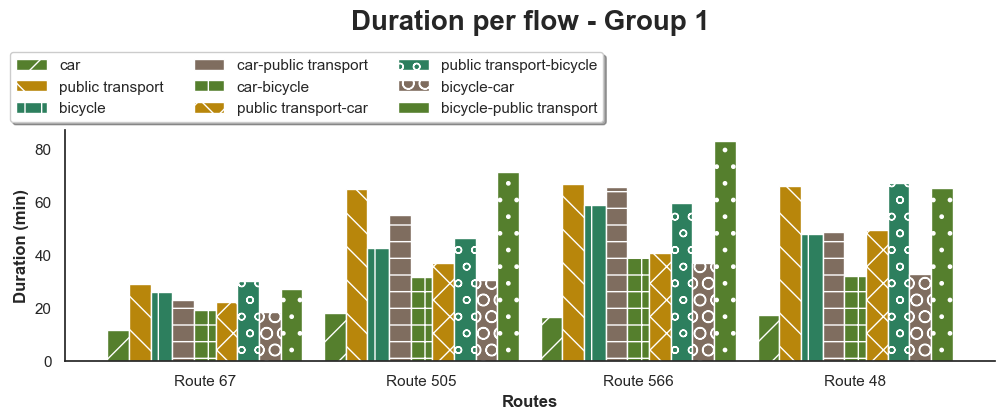

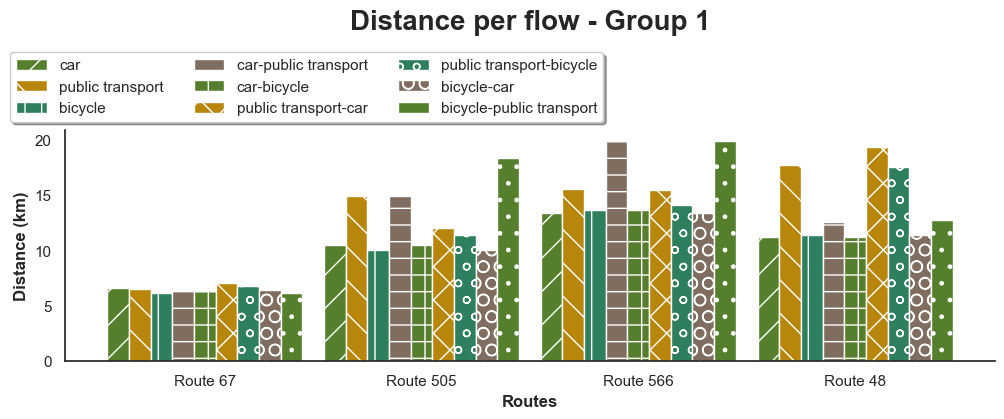

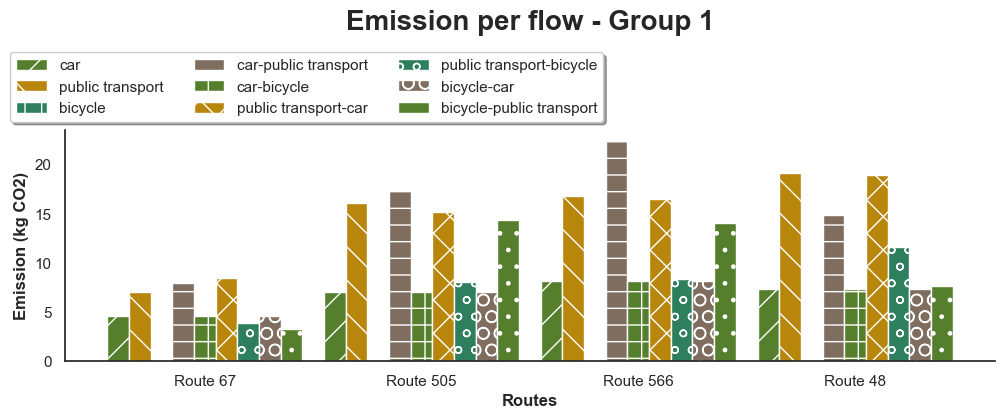

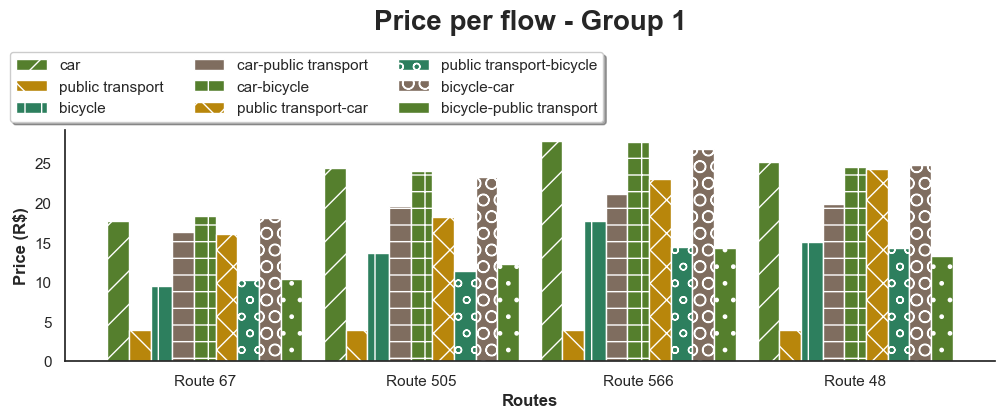

group 2
[272.0, 563.0, 584.0, 303.0]


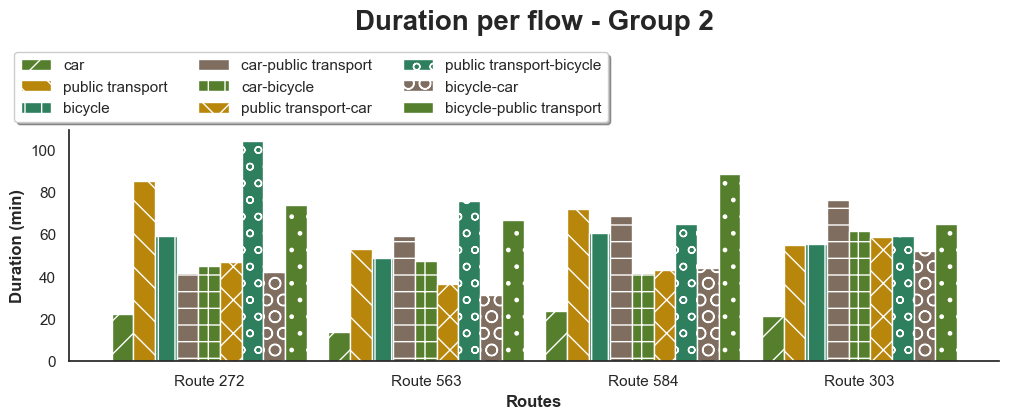

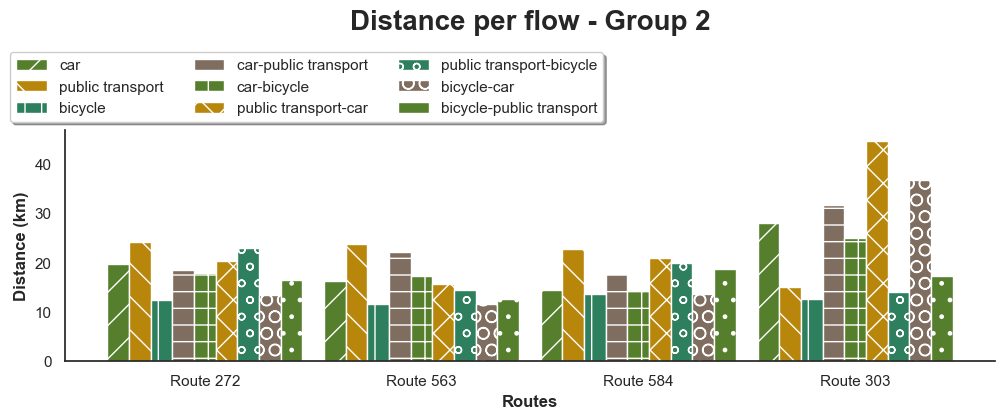

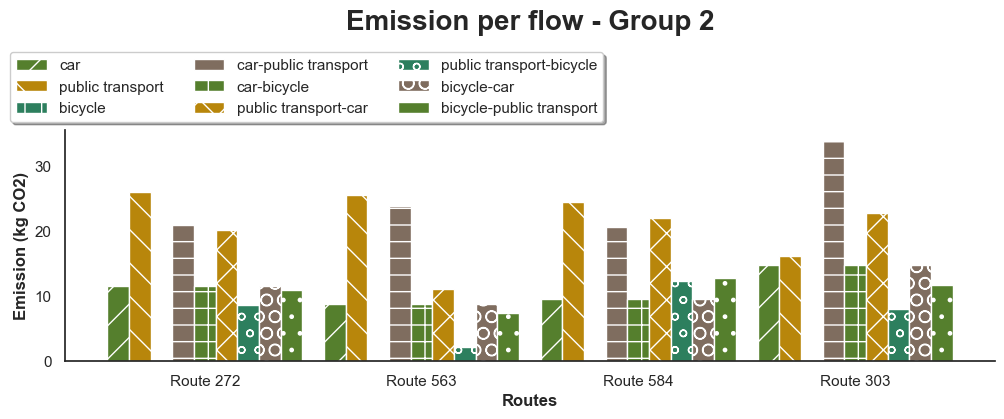

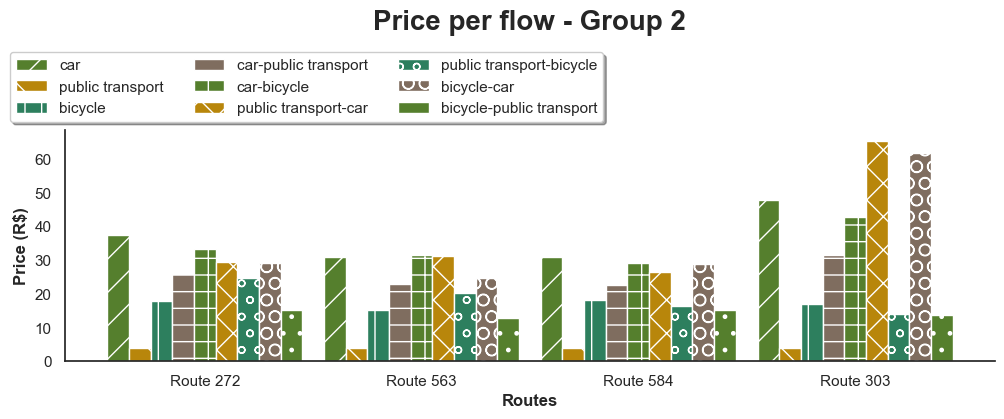

group 3
[588.0, 178.0, 171.0, 241.0]


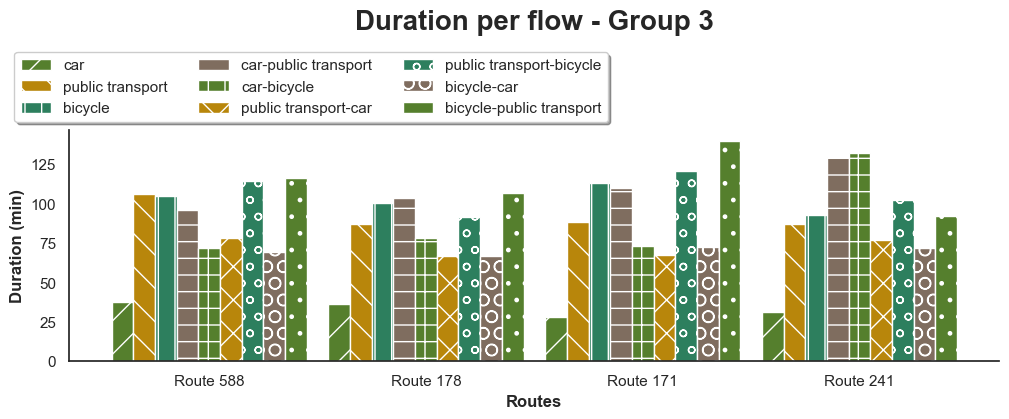

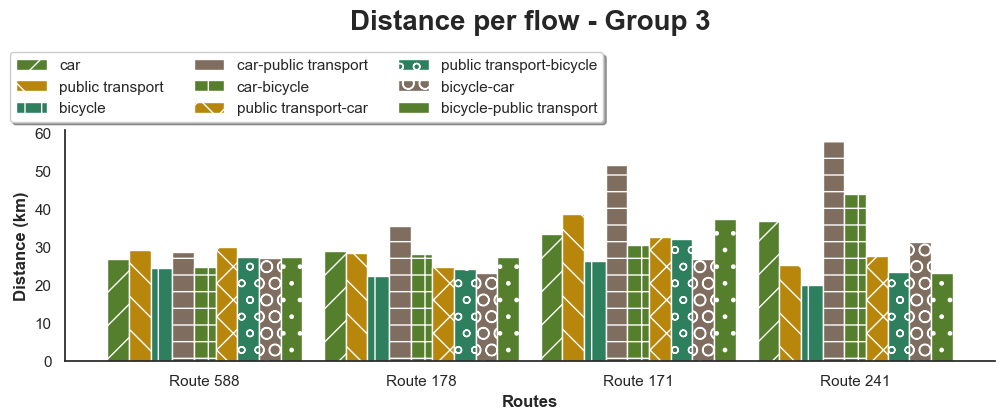

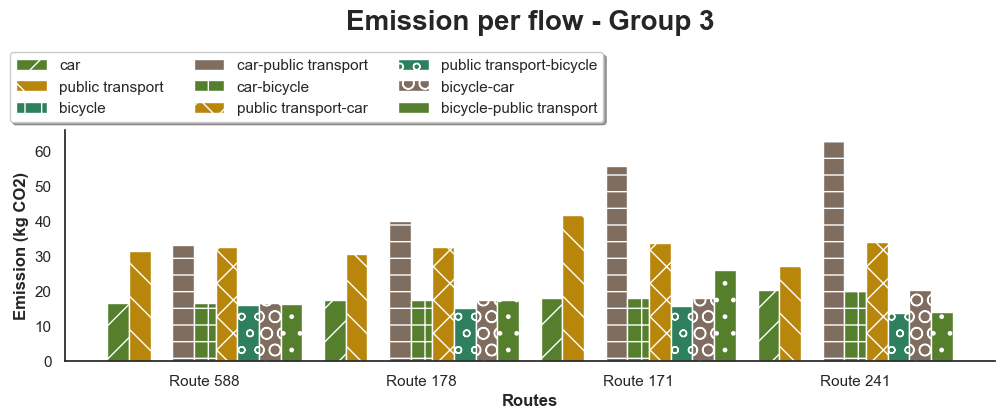

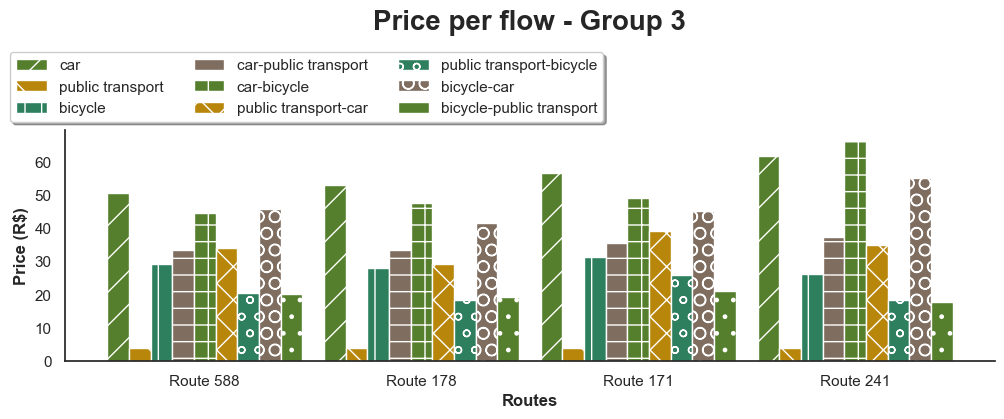

In [32]:
## barplot
rd.seed(10)

translator = {"distance": "Distance (km)","duration": "Duration (min)","price": "Price (R$)", "emission": "Emission (kg CO2)"}

for j in range(len(distance_wind)):
    print("group",j+1)
    sampl = rd.sample(sorted(windows[j].index),4)
    print(sampl)

    group = dataf_new.loc[dataf_new['setID'].isin(sampl)]
    routes = list(map(lambda x: f"Route {int(x)}",sampl))
    for i in ylabels:
        upper = i[0].upper() + i[1:]
        title = f"{upper} per flow - Group {j+1}"
        bars = getBars(group,labels,i)
        plotBars(bars,translator[i],labels,routes,title,fname=title)
    

group 1


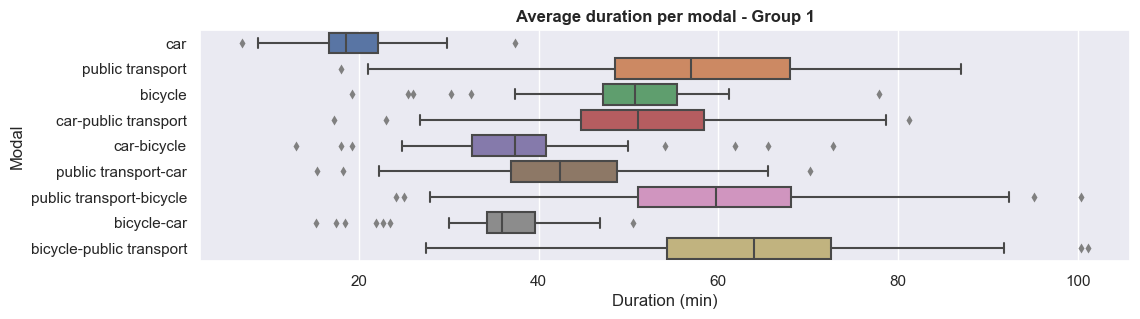

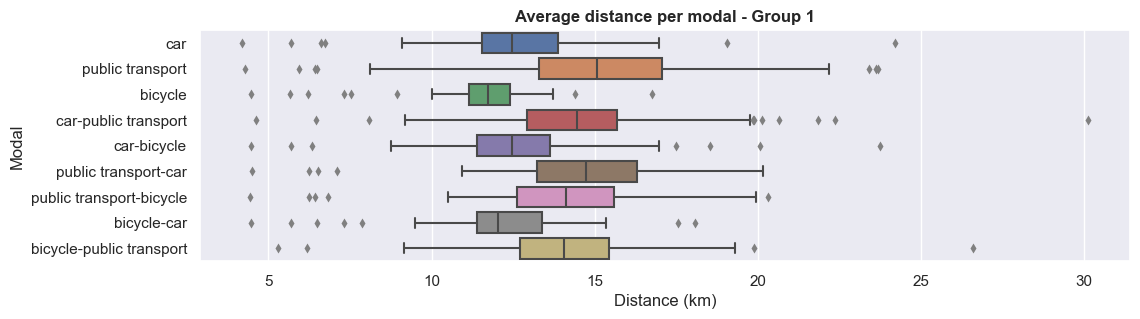

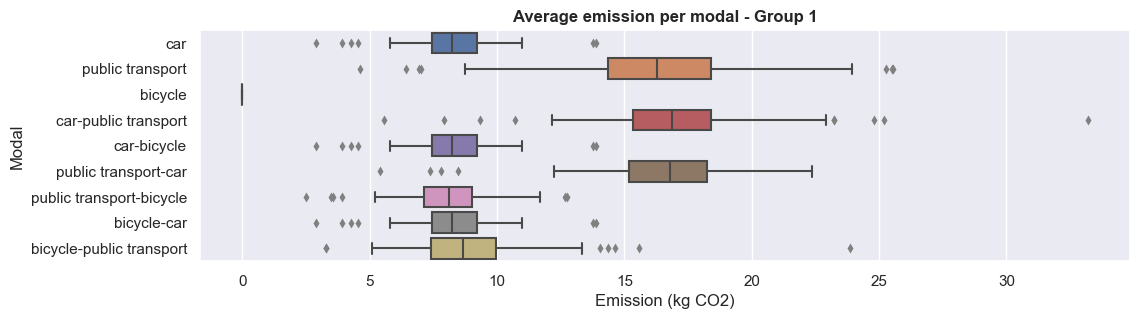

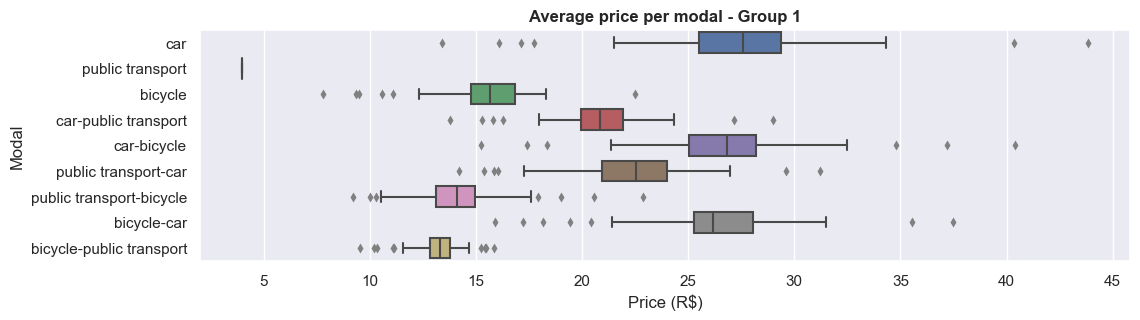

group 2


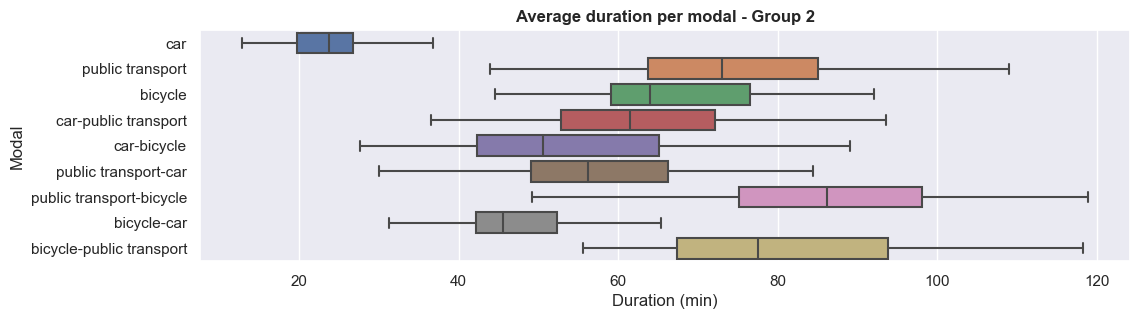

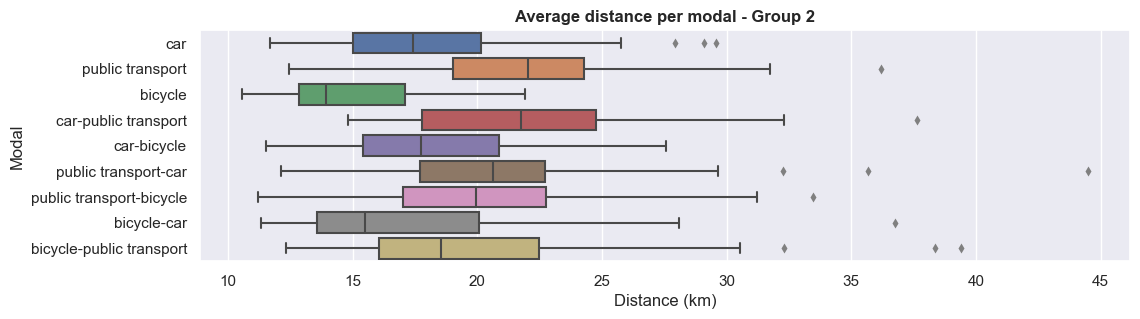

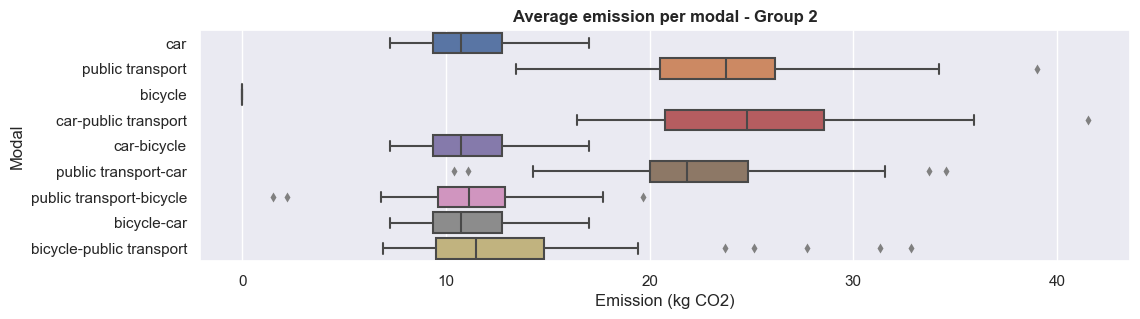

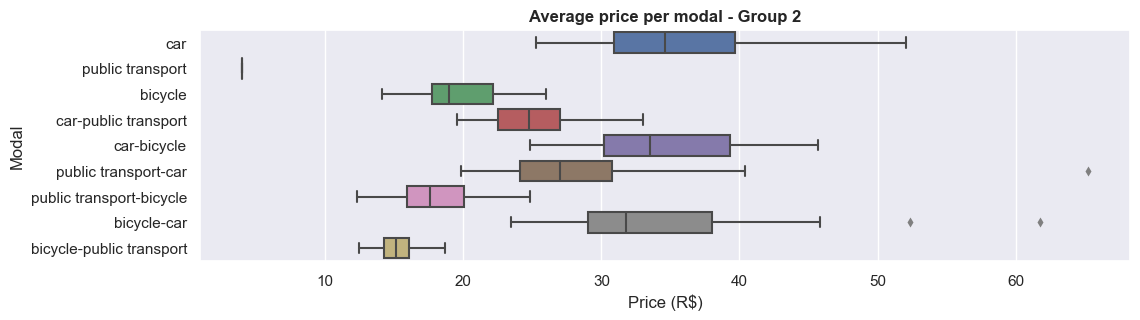

group 3


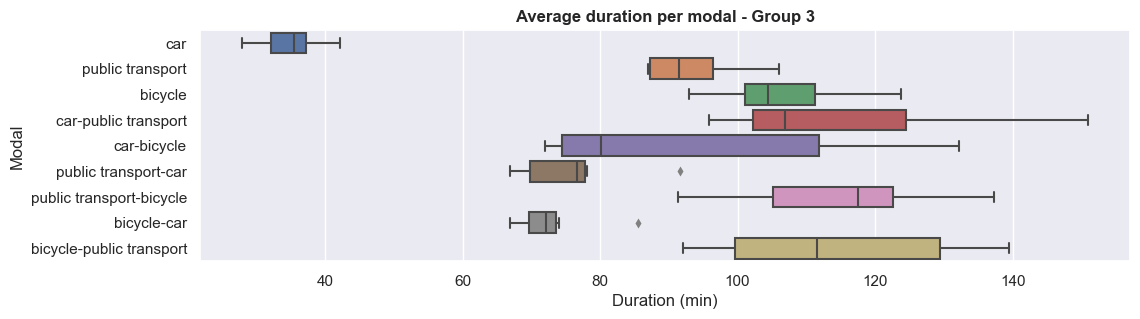

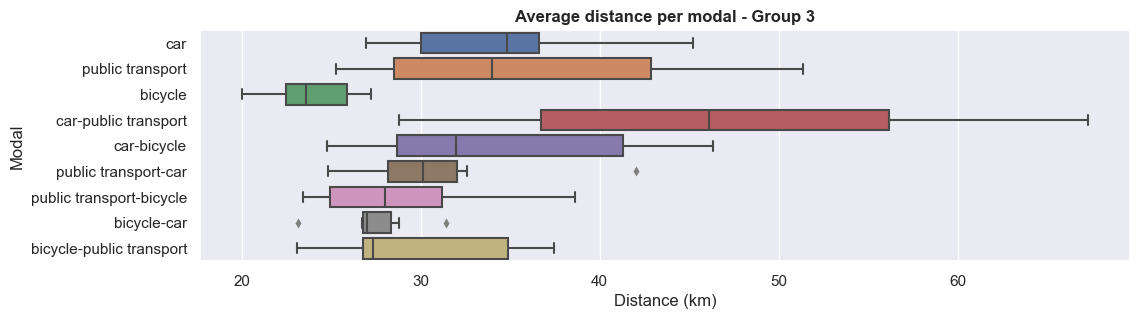

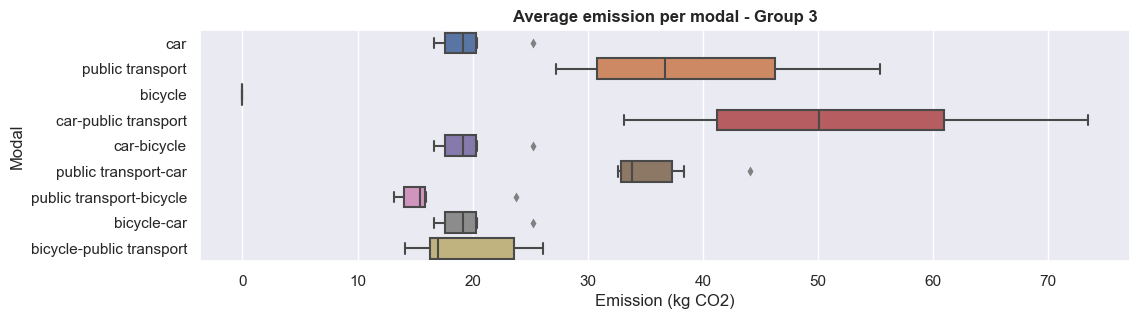

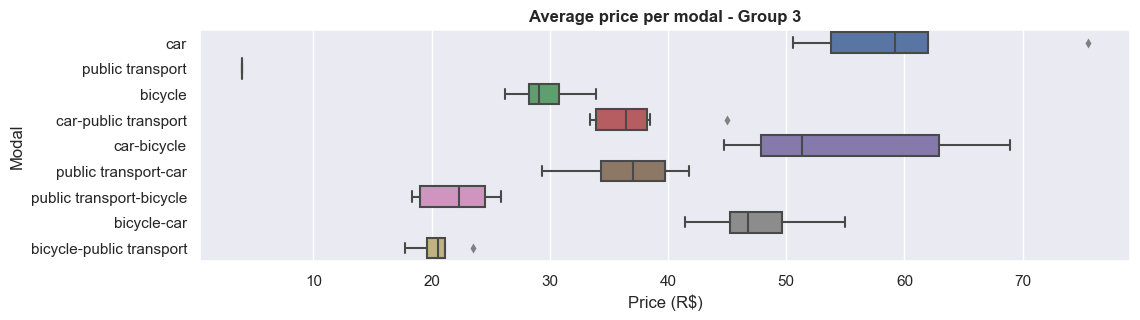

In [58]:
## boxplot
for j in range(len(distance_wind)):
    print("group",j+1)

    group = dataf_new.loc[dataf_new['setID'].isin(windows[j].index)]

    for i in range(len(ylabels)):
        #upper = ylabels[i][0].upper() + ylabels[i][1:]
        title = f"Average {ylabels[i]} per modal - Group {j+1}"
        plotBoxPlots(group,translator[ylabels[i]],title,ylabels[i],"modal",fname=title)

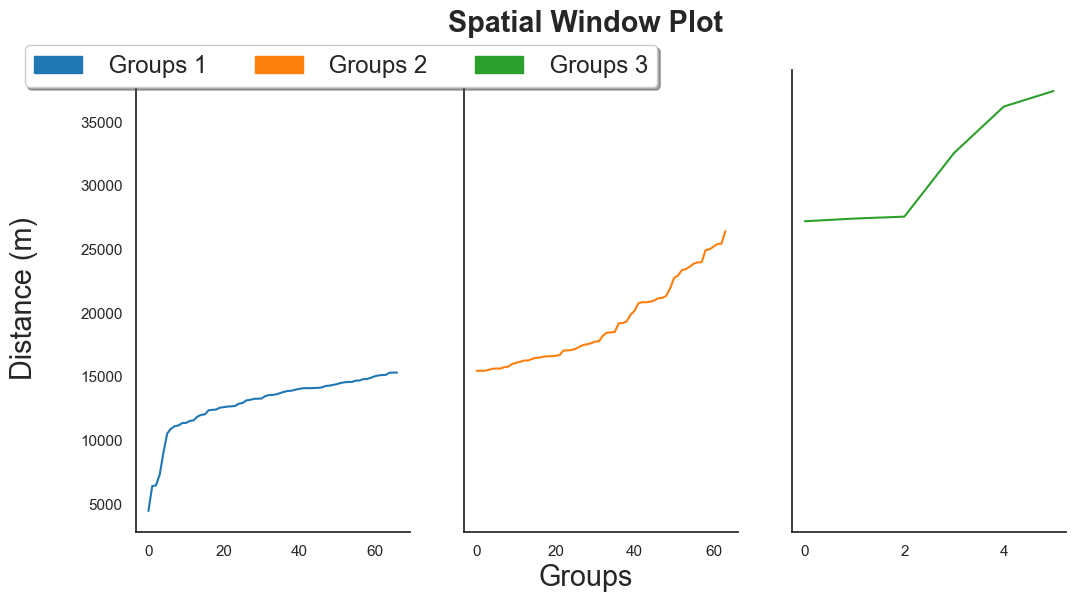

In [169]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=False,sharey=True,
                                    figsize=(12, 6))
values1 = sorted(series_wind1.values.tolist())
values2 = sorted(series_wind2.values.tolist())
values3 = sorted(series_wind3.values.tolist())

ax0.plot(range(len(values1)), values1,color="tab:blue",label='group 1',linestyle="solid")
ax1.plot(range(len(values2)), values2,color="tab:orange",label='group 2',linestyle="solid")
ax2.plot(range(len(values3)), values3,color="tab:green",label='group 3',linestyle="solid")

#ax0.set_xlabel("Window 1",fontsize="xx-large")
#ax1.set_xlabel("Window 2",fontsize="xx-large")
#ax2.set_xlabel("Window 3",fontsize="xx-large")

#ax0.set_xticks([])
#ax1.set_xticks([])
#ax2.set_xticks([])

leg_g1 = mpatches.Patch(color="tab:blue",label=" Groups 1")
leg_g2 = mpatches.Patch(color="tab:orange",label=" Groups 2")
leg_g3 = mpatches.Patch(color="tab:green",label=" Groups 3")

plt.legend(loc="upper right",
           bbox_to_anchor=(-0.45,1.08),
           ncol=3,
           fancybox=True,
           shadow=True,
           fontsize="x-large",
           handles = [leg_g1,leg_g2,leg_g3])


#ax0.set_title('Window 1')
#ax1.set_title('Window 2')
#ax2.set_title('Window 3')

#ax0.set_xticklabels([])

fig.suptitle('Spatial Window Plot',fontsize="xx-large",fontweight="bold")
fig.supxlabel("Groups",fontsize="xx-large")
fig.supylabel("Distance (m)",fontsize="xx-large")

sns.set_style("whitegrid", {'grid.linestyle': '--','axes.facecolor': '#F4F4F4'})

sns.despine(top=True,left=False)
plt.show()